# Imports

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import translators as ts
import fasttext
import warnings
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import normaltest
from iso_language_codes import language_name
from nltk import pos_tag_sents
from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

PATH_TO_FILE = "../data/train.csv"
PATH_TO_FASTTEXT_MODEL = "../results/models/lid.176.ftz"
CONFIDENCE = 5e-2

[nltk_data] Downloading package punkt to /home/denisio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/denisio/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/denisio/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [57]:
data = pd.read_csv(PATH_TO_FILE)
data.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [58]:
print(f"Dataset length:{len(data)}")

Dataset length:34250


# Wordcloud

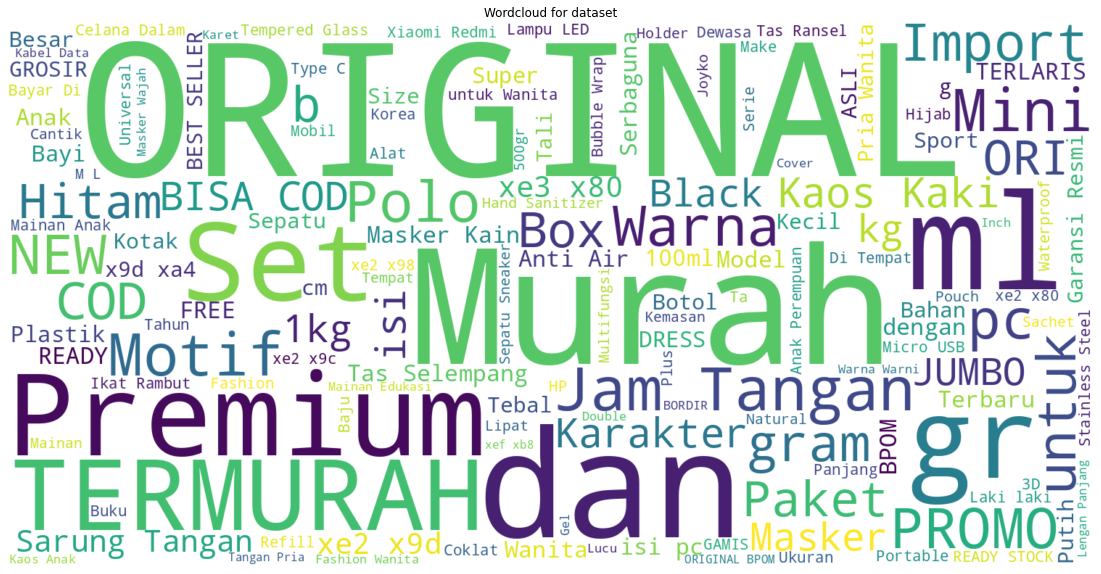

In [59]:
plt.figure(figsize=(20, 10))
wc = WordCloud(
    stopwords=STOPWORDS,
    background_color="white",
    contour_width=2,
    contour_color="orange",
    width=1500,
    height=750,
    max_words=150,
    max_font_size=256,
    random_state=42,
)
wc.generate(" ".join(data["title"]))
plt.title("Wordcloud for dataset")
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Distribution of title length (characters)

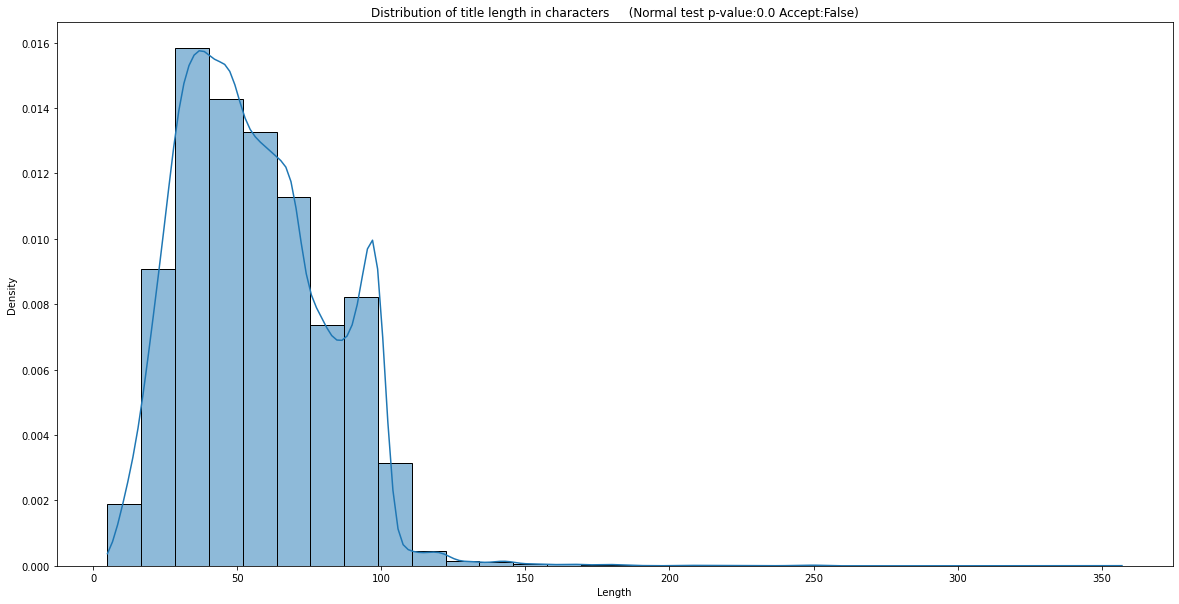

In [60]:
data["title_length_char"] = data["title"].str.len()
p_value = normaltest(data["title_length_char"])[1]
plt.figure(figsize=(20, 10))
plt.title(
    f"Distribution of title length in characters \
    (Normal test p-value:{p_value} Accept:{p_value > CONFIDENCE})"
)
sns.histplot(data=data, x="title_length_char",
             kde=True, stat="density", bins=30)
plt.xlabel("Length")
plt.show()

# Text cleaning

In [61]:
cleaned_title = data["title"].str.lower()
# remove punctuation
cleaned_title = cleaned_title \
                        .str.replace(r"[^\w\s]", "", regex=True)
# remove trailing spaces
cleaned_title = cleaned_title \
                        .str.replace(r"\s+$", "", regex=True)
# remove encoding mistakes
cleaned_title = cleaned_title \
                        .str.replace(r"x\d+$", "", regex=True)
# remove words with length less than 3
data["cleaned_title"] = cleaned_title \
                        .str.replace(r"\W*\b\w{1,3}\b", "", regex=True)

# Distribution of title length (words)

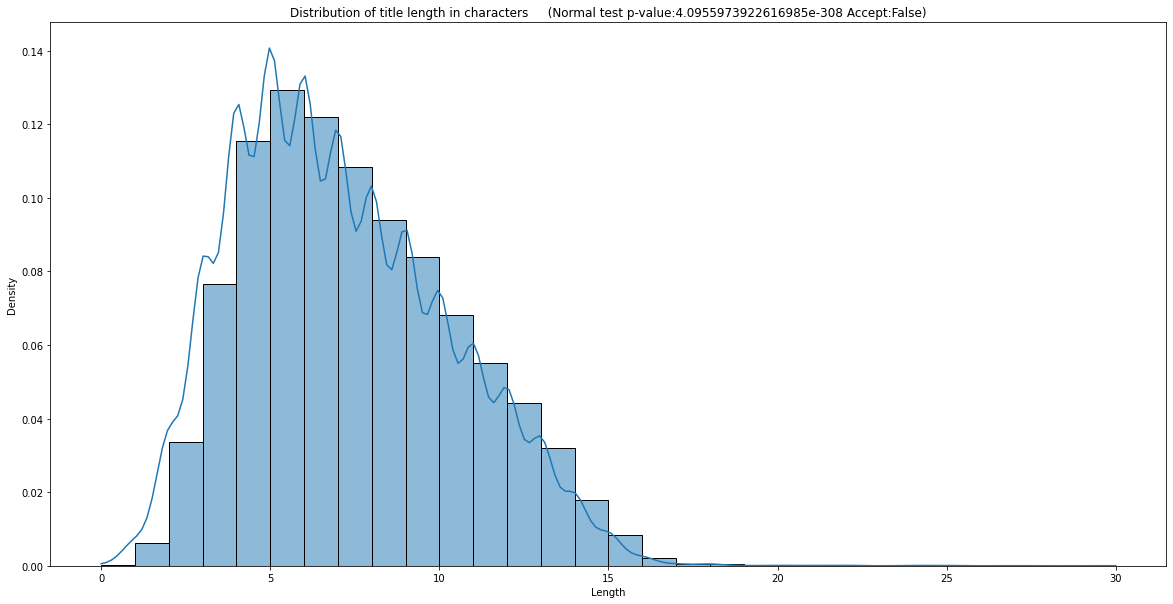

In [62]:
data["title_length_words"] = data["cleaned_title"] \
                            .map(lambda x: len(x.split()))
p_value = normaltest(data["title_length_words"])[1]
plt.figure(figsize=(20, 10))
plt.title(
    f"Distribution of title length in characters \
    (Normal test p-value:{p_value} Accept:{p_value > CONFIDENCE})"
)
sns.histplot(data=data, x="title_length_words",
             kde=True, stat="density", bins=30)
plt.xlabel("Length")
plt.show()

# Language detection

In [63]:
fmodel = fasttext.load_model(PATH_TO_FASTTEXT_MODEL)
languages = fmodel.predict(data["cleaned_title"].tolist())[0]
data["language"] = np.reshape(languages, -1)
data["language"] = data["language"].str.replace("__label__", "")
data["language"] = data["language"].map(
    lambda x: language_name(x) if len(x) == 2 else None
)

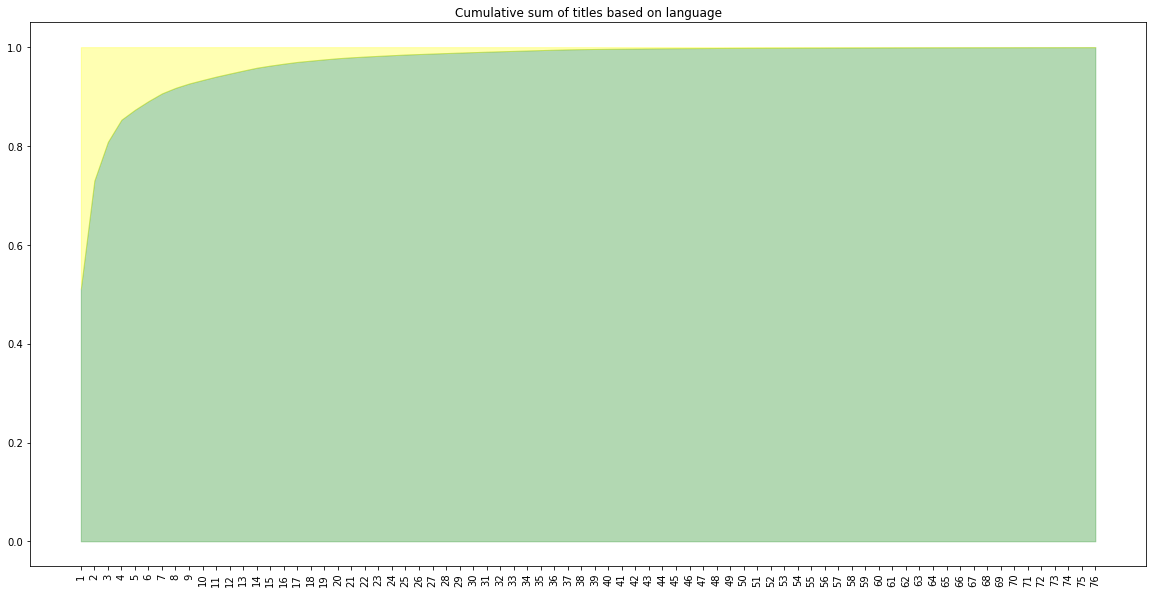

In [64]:
counts = data["language"].value_counts()
sums = np.cumsum(counts.values) / np.sum(counts.values)
xs = range(1, len(sums) + 1)
plt.figure(figsize=(20, 10))
plt.title("Cumulative sum of titles based on language")
plt.fill_between(xs, sums, color="green", alpha=0.3)
plt.fill_between(xs, sums, 1, color="yellow", alpha=0.3)
plt.xticks(xs, rotation=90)
plt.show()

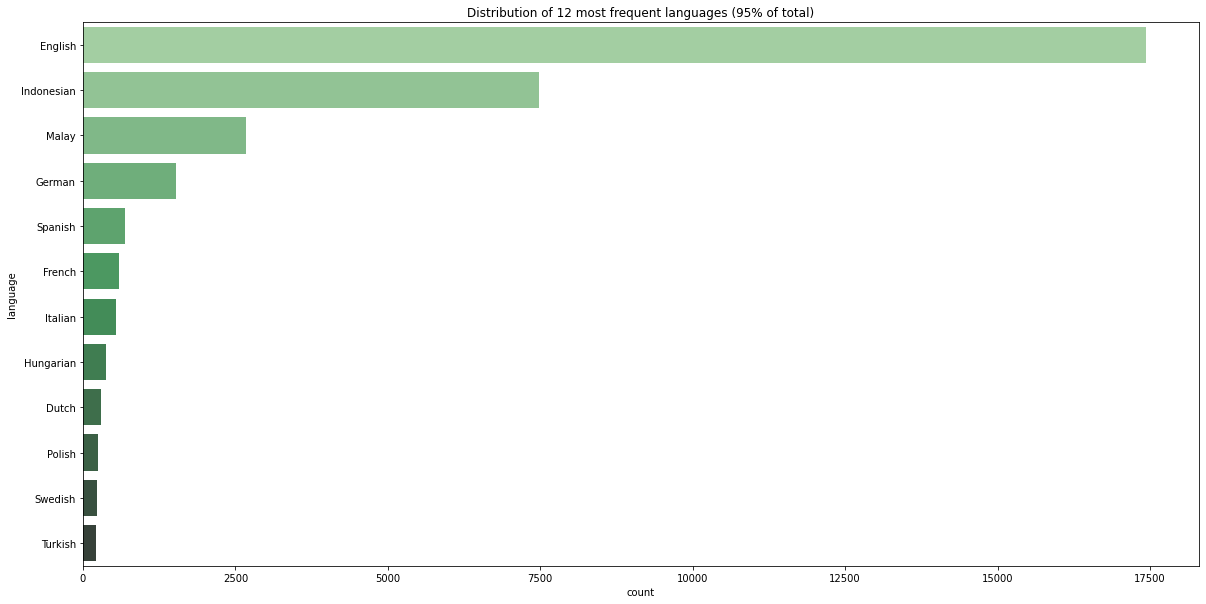

In [65]:
top_n = (sums < 0.95).sum()
plt.figure(figsize=(20, 10))
plt.title(f"Distribution of {top_n} most frequent languages (95% of total)")
sns.countplot(
    data=data, y="language", palette="Greens_d",
    order=counts.iloc[:top_n].index
)
plt.show()

# N-gram distributions

In [66]:
def get_n_grams(corpus: np.array, gram_size: int,
                top_n: int) -> pd.DataFrame:
    vec = CountVectorizer(ngram_range=(gram_size, gram_size))
    vec.fit(corpus)
    bag_of_words = vec.transform(corpus)
    gram_freq = bag_of_words.sum(axis=0)
    gram_freq = [
        [gram, gram_freq[0, idx]]
        for gram, idx in vec.vocabulary_.items()
    ]
    gram_freq = sorted(gram_freq, key=lambda x: x[1], reverse=True)
    gram_freq = pd.DataFrame([
        [f"{gram[0]}(in en:{ts.google(gram[0])})", gram[1]]
        for gram in gram_freq[:top_n]],
        columns=[f'{gram_size}-gram', 'Frequency'])
    return gram_freq

In [67]:
def plot_grams(gram_freqs: pd.DataFrame, ax):
    ax.set_title(
        f"Top {len(gram_freqs)} most frequent {gram_freqs.columns[0]}"
    )
    sns.barplot(data=gram_freqs, y=gram_freqs.columns[0],
                x='Frequency', palette="crest", ax=ax)

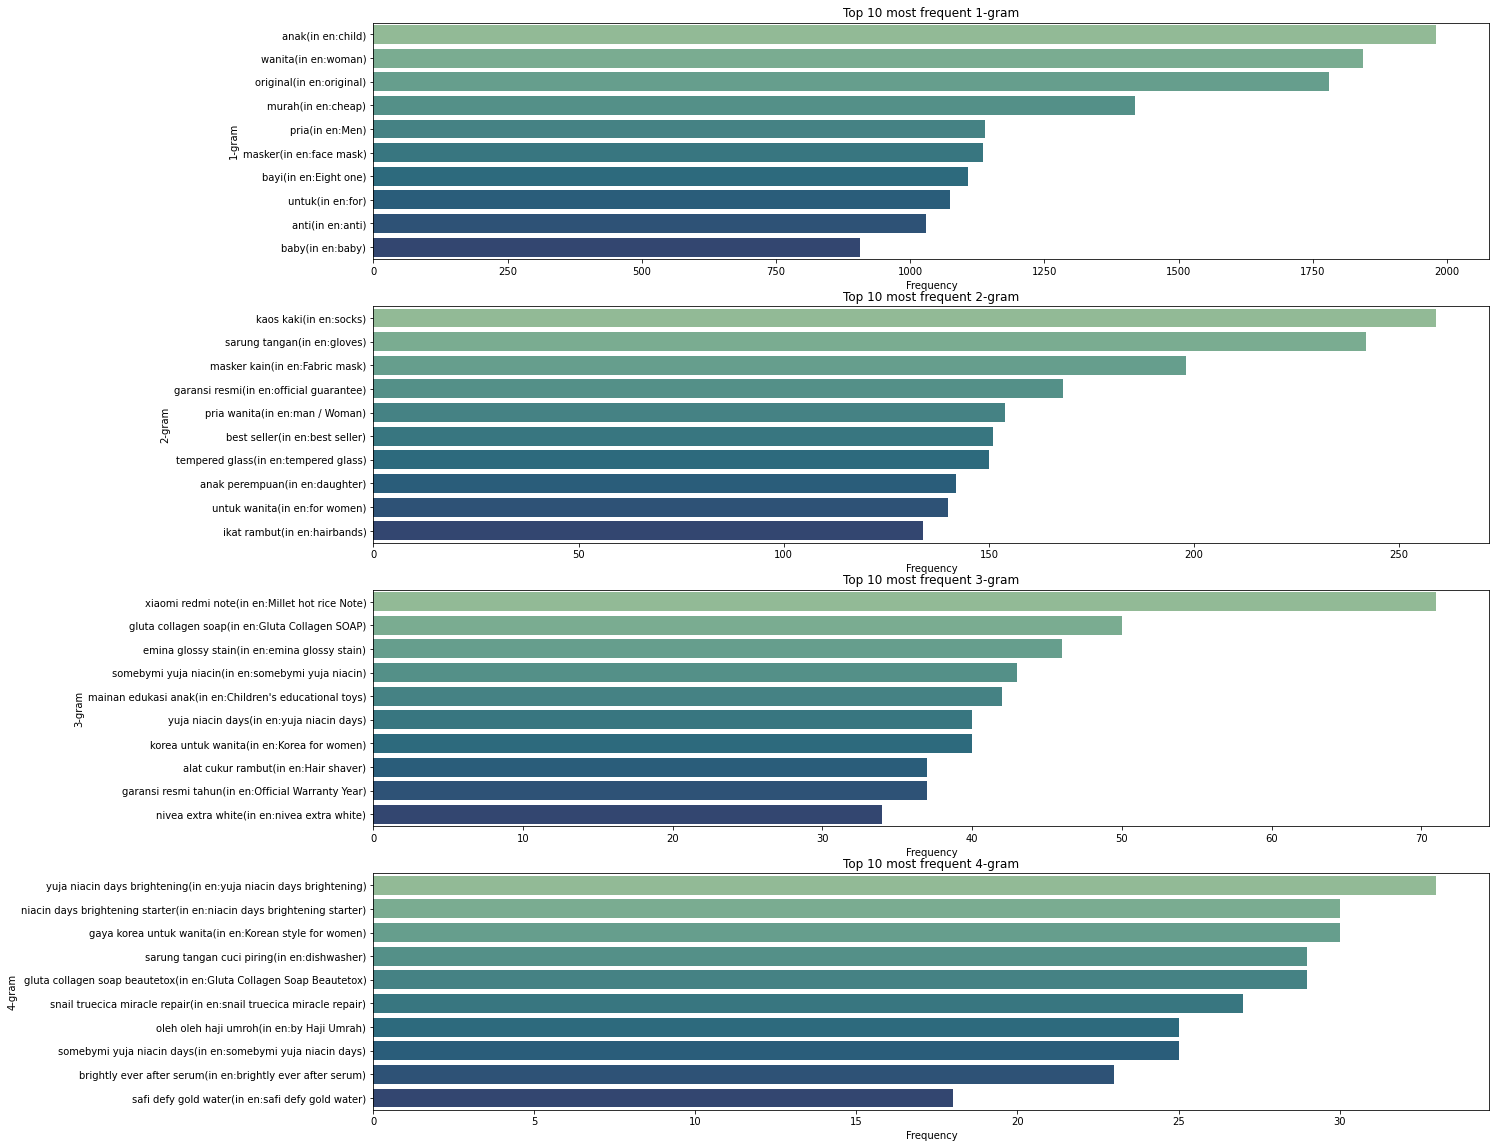

In [68]:
figure, axes = plt.subplots(4, figsize=(20, 20))
gram_sizes = range(1, 5)
for gram_size in gram_sizes:
    grams = get_n_grams(data['cleaned_title'], gram_size, 10)
    plot_grams(grams, axes[(gram_size - 1)])
plt.show()

# Part-of-speech distribution(English)

In [201]:
eng_titles = data.loc[
    data['language'] == "English", 'cleaned_title'
].str.split()
pos_tags = np.array(pos_tag_sents(eng_titles, tagset='universal'))
pos_tags = [items[1] for sentence in pos_tags for items in sentence]
freqs = pd.DataFrame(Counter(pos_tags).items(), columns=['POS', 'Freqs'])
freqs['Freqs'] = freqs["Freqs"]/np.sum(freqs["Freqs"])
freqs = freqs[freqs["Freqs"] > 0.01]
freqs.loc[len(freqs)] = ["Other", 1 - freqs["Freqs"].sum()]

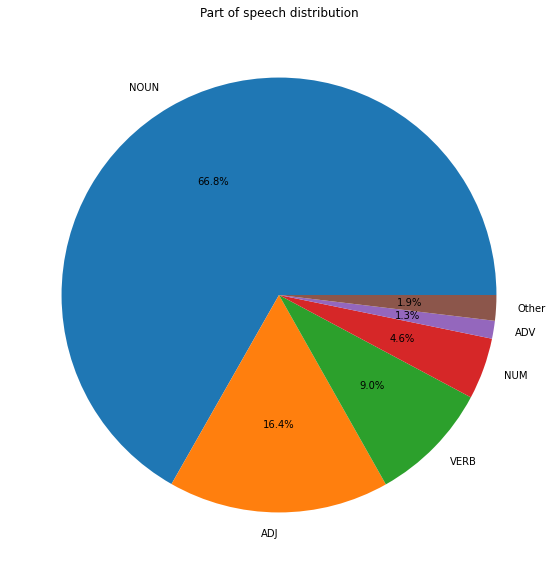

In [213]:
plt.figure(figsize=(10, 10))
plt.title("Part of speech distribution")
plt.pie(freqs["Freqs"], labels=freqs["POS"],
        autopct='%1.1f%%')
plt.gcf().set_facecolor("white")
plt.show()